In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def file_reader(filename):
    with open(filename) as f:
        lines = f.readlines()
        m = int(lines[0].split(" ")[0])
        Q = int(lines[0].split(" ")[1])
        lines = lines[1:]
        coord = [[int(f.split(" ")[1]),int(f.split(" ")[2])] for f in lines]
        req = [int(f.split(" ")[3]) for f in lines]
        return m, Q, coord, req

In [34]:
class Map:
    def __init__(self, coordinates, request, start_pheromon):
        self.center_id = np.where(np.array(request)==0)[0][0] + 1
        self.coordinates = coordinates
        self.req = request
        self.pheromon = np.ones((len(request),len(request)))*start_pheromon
        
    def distance(self, id1, id2):
        c1 = np.array(self.coordinates[id1-1])
        c2 = np.array(self.coordinates[id2-1])
        return np.sqrt(np.sum((c1-c2)*(c1-c2)))
    
    def evapurate_pheromon(self,ro, theta, Lavg):
        for i in range(len(self.pheromon)):
            for j in range(len(self.pheromon[i])):
                self.pheromon[i][j] = (ro + theta/Lavg)*self.pheromon[i][j]
    def update_pheromon(self, id1, id2, beta, alpha, sigma, i, Li):
        deltaph = (sigma - i)/Li
        if i == 0:
            deltaph = deltaph + sigma / Li
        self.pheromon[id1-1][id2-1] = self.pheromon[id1-1][id2-1] + deltaph #?

class Ant:
    def __init__(self, mapp, Q):
        self.coordinate = mapp.coordinates[mapp.center_id-1]
        self.mapp = mapp
        self.Q = Q + 0 
        self.path = [self.mapp.center_id]
    def move(self, id):
        self.path.append(id)
        self.Q = self.Q - self.mapp.req[id - 1]
        self.coordinate = self.mapp.coordinates[id - 1]
        self.mapp.req[id - 1] = 0
    def available_node(self):
        #ids = np.array([i+1 for i in range(len(self.mapp.req)) if [self.Q + 1 > self.mapp.req[i]] and not i+1 in self.path ])
        ids = []
        for i in range(len(self.mapp.req)):
            if self.Q + 1 > self.mapp.req[i] and self.mapp.req[i]>0:
                if not i+1 in self.path :
                    ids.append(i+1)
        return np.array(ids)
    def total_distance(self):
        d = 0 
        for p in range(len(self.path)-1):
            d = d + self.mapp.distance(self.path[p],self.path[p+1])
        return d
    def next_id(self, ro, beta, alpha, past_id):
        if np.sum(self.mapp.req)==0:
            return -1
        n = self.available_node()
        if len(n)==0:
            return -1
        p = [self.mapp.pheromon[past_id-1][i-1]**alpha/self.mapp.distance(past_id,i)**beta for i in n]#*Q?
        p = p/np.sum(p)
        return np.random.choice(n, p = p)

class Colony:
    def __init__(self, coordinates, request, start_pheromon, Q, ant_count):
        self.ant_count = ant_count
        self.request = request
        self.mapp = Map(coordinates, request, start_pheromon)
        self.Q = Q
        self.mind = 1000
        self.maxd = 0
    def costfunction(self, ants, costumer_importance = 0):
        d = -1*np.sum([int(r==0) for r in self.mapp.req])*costumer_importance
        for ant in ants:
            d = d + ant.total_distance()
        return d 
        
    def main(self, iterations, ro, beta, alpha, theta, sigma):
        best_path = []
        best_path_cost = 100000
        for i in range(iterations):
            '''
            set request for each map
            creat ants
            for each ant:
                until finished:
                    find next node
                    move to next node
                back to center
            calculate cost
            save best path
            update pheromon
            '''   
            self.mapp.req = np.copy(self.request)
            ants = [Ant(self.mapp,self.Q) for i in range(self.ant_count)]
            for ant in ants:
                #path = [self.mapp.center_id]
                id = self.mapp.center_id
                while True:
                    id = ant.next_id( ro, beta, alpha, id)
                    if id == -1:
                        break
                    ant.move(id)
                    #path.insert(0,id)
                #path = path[1:]
                #for p in path:
                #    ant.path.append(p)
                ant.path.append(self.mapp.center_id)
            L = [ant.total_distance() for ant in ants]
            self.mapp.evapurate_pheromon(ro, theta, np.mean(L))
            ind = np.flip(np.argpartition(L, sigma)[-1*sigma:])
            for i in range(len(ind)):
                ant = ants[ind[i]]
                for p in range(len(ant.path)-1):
                    self.mapp.update_pheromon(ant.path[p],ant.path[p+1],beta, alpha, sigma, i, L[ind[i]])
                    self.mapp.update_pheromon(ant.path[p+1],ant.path[p],beta, alpha, sigma, i, L[ind[i]])
            cost = self.costfunction(ants)
            if cost < best_path_cost:
                #print("best path updated with cost:")
                #print(cost)
                best_path_cost = cost
                best_path = [a.path for a in ants]
                self.mind = np.min(L)
                self.maxd = np.max(L)
        return best_path_cost, best_path

### Read from file:

In [4]:
m, Q, c, r = file_reader('./data.txt')

### compare parameters influence on cost:

In [36]:
best_cost_per_sigma = []
for sigma in [1,2,3,4,5]:
    temp = []
    for i in range(100):
        b, _ = Colony(c, r, 0.001, Q, m).main(100, 0.8, 5, 2, 80, sigma)
        temp.append(b)
    best_cost_per_sigma.append(np.mean(temp))

Text(0.5, 1.0, 'best sigma')

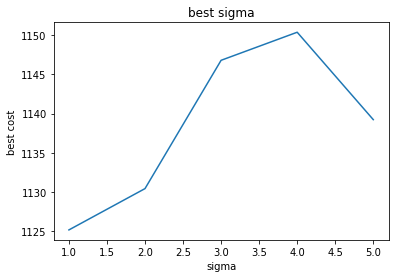

In [37]:
plt.xlabel("sigma")
plt.ylabel("best cost")
plt.plot([1,2,3,4,5],best_cost_per_sigma)
plt.title("best sigma")

In [5]:
best_cost_per_theta = []
for theta in [10,20,40,80,100]:
    temp = []
    for i in range(100):
        b, _ = Colony(c, r, 0.001, Q, m).main(100, 0.8, 5, 2, theta, 1)
        temp.append(b)
    best_cost_per_theta.append(np.mean(temp))

Text(0.5, 1.0, 'best theta')

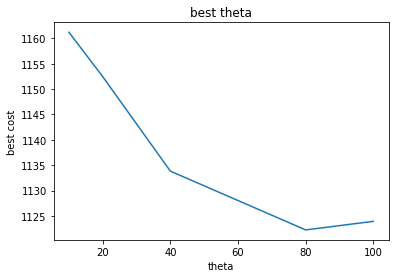

In [6]:
plt.xlabel("theta")
plt.ylabel("best cost")
plt.plot([10,20,40,80,100],best_cost_per_theta)
plt.title("best theta")

In [8]:
best_cost_per_alpha = []
for alpha in [1,2,3,4]:
    temp = []
    for i in range(100):
        b, _ = Colony(c, r, 0.001, Q, m).main(100, 0.8, 5, alpha, 80, 1)
        temp.append(b)
    best_cost_per_alpha.append(np.mean(temp))

Text(0.5, 1.0, 'best alpha')

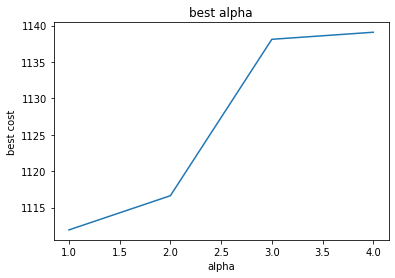

In [9]:
plt.xlabel("alpha")
plt.ylabel("best cost")
plt.plot([1,2,3,4],best_cost_per_alpha)
plt.title("best alpha")

In [10]:
best_cost_per_beta = []
for beta in [1,2,3,4,5,6,7]:
    temp = []
    for i in range(100):
        b, _ = Colony(c, r, 0.001, Q, m).main(100, 0.8, beta, 1, 80, 1)
        temp.append(b)
    best_cost_per_beta.append(np.mean(temp))

Text(0.5, 1.0, 'best beta')

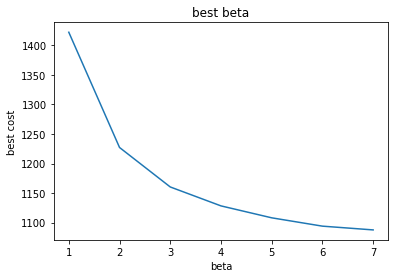

In [11]:
plt.xlabel("beta")
plt.ylabel("best cost")
plt.plot([1,2,3,4,5,6,7],best_cost_per_beta)
plt.title("best beta")

In [5]:
best_cost_per_ro = []
for ro in [0.1,0.3,0.7,0.8,0.9,0.99]:
    temp = []
    for i in range(100):
        b, _ = Colony(c, r, 0.001, Q, m).main(100, ro, 7, 1, 80, 1)
        temp.append(b)
    best_cost_per_ro.append(np.mean(temp))

Text(0.5, 1.0, 'best ro')

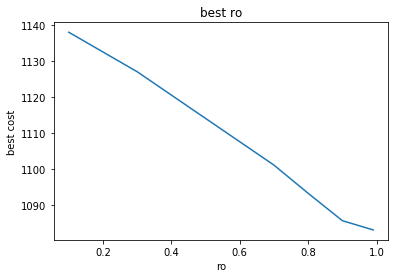

In [6]:
plt.xlabel("ro")
plt.ylabel("best cost")
plt.plot([0.1,0.3,0.7,0.8,0.9,0.99],best_cost_per_ro)
plt.title("best ro")

In [7]:
best_cost_per_initph = []
for ph in [0,0.01,0.1,1]:
    temp = []
    for i in range(100):
        b, _ = Colony(c, r, ph, Q, m).main(100, 0.99, 7, 1, 80, 1)
        temp.append(b)
    best_cost_per_initph.append(np.mean(temp))

C:\Users\banafshVBTS\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide
C:\Users\banafshVBTS\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


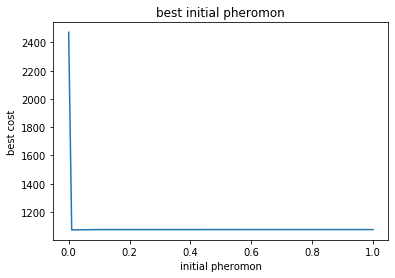

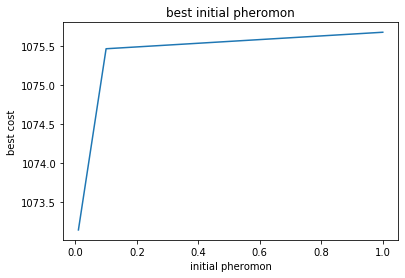

In [13]:
plt.xlabel("initial pheromon")
plt.ylabel("best cost")
plt.plot([0,0.01,0.1,1],best_cost_per_initph)
plt.title("best initial pheromon")
plt.show()
plt.xlabel("initial pheromon")
plt.ylabel("best cost")
plt.plot([0.01,0.1,1],best_cost_per_initph[1:])
plt.title("best initial pheromon")
plt.show()

### cost for multiple max iterations:

In [24]:
best_cost_per_iteration_mean = []
mind_mean = []
maxd_mean = []
best_cost_per_iteration_min = []
mind_min = []
maxd_min = []
for it in [100,200,300,400,700,1000,2000]:
    temp = []
    temp2 = []
    temp3 = []
    for i in range(100):
        colony = Colony(c, r, 0.1, Q, m)
        b, _ = colony.main(it, 0.99, 7, 1, 100, 1)
        temp.append(b)
        temp2.append(colony.mind)
        temp3.append(colony.maxd)
    best_cost_per_iteration_mean.append(np.mean(temp))
    mind_mean.append(np.mean(temp2))
    maxd_mean.append(np.mean(temp3))
    best_cost_per_iteration_min.append(np.min(temp))
    mind_min.append(np.min(temp2))
    maxd_min.append(np.min(temp3))

C:\Users\banafshVBTS\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in double_scalars
  app.launch_new_instance()
C:\Users\banafshVBTS\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide
C:\Users\banafshVBTS\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


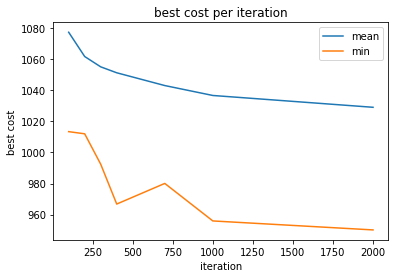

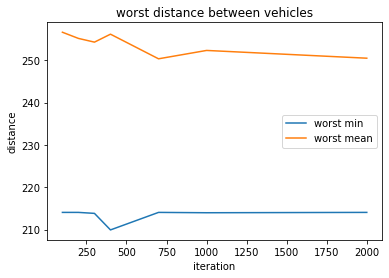

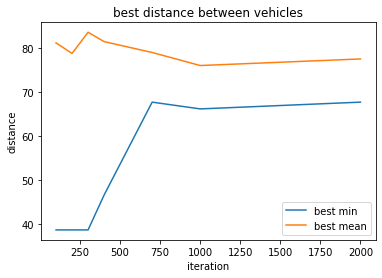

In [28]:
plt.xlabel("iteration")
plt.ylabel("best cost")
plt.plot([100,200,300,400,700,1000,2000],best_cost_per_iteration_mean, label = "mean")
plt.plot([100,200,300,400,700,1000,2000],best_cost_per_iteration_min, label = "min")
plt.title("best cost per iteration")
plt.legend()
plt.show()
plt.xlabel("iteration")
plt.ylabel("distance")
plt.plot([100,200,300,400,700,1000,2000],maxd_min, label = "worst min")
plt.plot([100,200,300,400,700,1000,2000],maxd_mean, label = "worst mean")
plt.title("worst distance between vehicles")
plt.legend()
plt.show()
plt.xlabel("iteration")
plt.ylabel("distance")
plt.plot([100,200,300,400,700,1000,2000],mind_min, label = "best min")
plt.plot([100,200,300,400,700,1000,2000],mind_mean, label = "best mean")
plt.title("best distance between vehicles")
plt.legend()
plt.show()

In [33]:
colony = Colony(c, r, 0.01, Q, m)
print(colony.main(2000, 0.99, 7, 1, 80, 1))

(1004.2106322959204, [[1, 25, 16, 31, 21, 33, 19, 23, 24, 1], [1, 14, 4, 39, 6, 1], [1, 27, 12, 7, 2, 37, 18, 22, 1], [1, 29, 10, 30, 13, 38, 32, 15, 26, 36, 1], [1, 35, 28, 11, 17, 5, 34, 3, 8, 1], [1, 9, 20, 1]])
